# Topic Modeling: Reagan's Nicaragua Rhetoric (1980-1988)

**Research Question:** What are the latent themes in Reagan's Nicaragua discourse, and what is the relative weight of a *counternarcotics* framing versus an *anticommunism/counterinsurgency* framing?

**Corpus:** 485 speeches, statements, and remarks by Ronald Reagan containing the word "Nicaragua," scraped from the [UCSB American Presidency Project](https://www.presidency.ucsb.edu/). Documents span August 1980 through December 1988.

**Approach:** We train two topic models -- **LDA** (Latent Dirichlet Allocation) and **NMF** (Non-negative Matrix Factorization) -- across three values of k (5, 10, 15 topics). We compare their coherence scores to assess topic quality, display the top words for each topic, and produce a document-topic distribution table mapping each speech to its dominant theme.

In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 2: Imports & Configuration
# ─────────────────────────────────────────────────────────────────────────────

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# --- NLP ---
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# --- Topic Modeling (scikit-learn) ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

# --- Coherence Scoring (gensim) ---
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# Download required NLTK data (runs once; safe to re-run)
nltk.download('punkt',        quiet=True)
nltk.download('punkt_tab',    quiet=True)
nltk.download('stopwords',    quiet=True)
nltk.download('wordnet',      quiet=True)

# ── Configuration ────────────────────────────────────────────────────────────
# Paths are relative to the notebook location inside '2. Topic_modelling/'
DATA_DIR  = "../1.Collection_midterm/ucsb_scraping/data/raw_texts/"
META_PATH = "../1.Collection_midterm/ucsb_scraping/data/metadata.csv"

K_VALUES     = [5, 10, 15]   # number of topics to evaluate
TOP_N        = 10            # top words to display per topic
RANDOM_STATE = 42            # seed for reproducibility

print("All imports successful.")

All imports successful.


---
## Step 1: Preprocessing

Before feeding text to a topic model, we need to clean and standardize it. This step is conceptually identical to preprocessing in R (e.g., with `quanteda` or `tm`), but done with Python's `nltk` and `re` libraries.

**Pipeline:**
1. **Remove bracketed stage directions** -- The UCSB transcripts include audience cues like `[Applause]`, `[Laughter]`, and `[Q--]`. These are metadata about the delivery context, not substantive rhetorical content, so we strip them with a regex.
2. **Lowercase** -- Ensures "Soviet" and "soviet" are treated as the same token.
3. **Remove punctuation and digits** -- Keep only alphabetic characters.
4. **Tokenize** -- Split text into a list of individual words (tokens).
5. **Remove stopwords** -- Two layers:
   - *Standard English stopwords* (NLTK): "the", "is", "at", etc.
   - *Custom domain stopwords*: High-frequency Reagan-speech words that appear across nearly all documents and add noise rather than signal. Critically, "nicaragua" and "nicaraguan" are also removed -- because this was the search keyword, they appear in virtually every document and cannot discriminate between topics.
6. **Lemmatize** -- Reduce words to their base form ("fighting" -> "fight", "soviets" -> "soviet"). In R this is analogous to `dfm_wordstem()`.
7. **Filter short tokens** -- Drop any token with fewer than 3 characters (removes noise like "uh", "ok").

In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 4: Preprocessing Pipeline
# ─────────────────────────────────────────────────────────────────────────────

# ── 1. Load metadata ─────────────────────────────────────────────────────────
metadata = pd.read_csv(META_PATH)
print(f"Metadata loaded: {len(metadata)} rows")
print(metadata.head(3))

# ── 2. Load raw texts in filename order ──────────────────────────────────────
filenames = sorted(
    [f for f in os.listdir(DATA_DIR) if f.endswith('.txt')]
)
print(f"\nText files found: {len(filenames)}")

raw_texts = {}
for fname in filenames:
    with open(os.path.join(DATA_DIR, fname), 'r', encoding='utf-8', errors='replace') as fh:
        raw_texts[fname] = fh.read()

# ── 3. Define stopwords ───────────────────────────────────────────────────────
standard_stops = set(stopwords.words('english'))

CUSTOM_STOPWORDS = {
    "america", "american", "americans", "people", "nation", "government",
    "president", "reagan", "united", "states", "would", "also", "said",
    "mr", "mrs", "secretary", "administration", "year", "years",
    "country", "world", "think", "know", "want", "get", "let", "make",
    "well", "going", "today", "new", "one", "time", "come", "back",
    "nicaragua", "nicaraguan",
    "congress", "house", "senate", "vote", "law", "policy", "support",
    "must", "us", "every", "even", "still", "last", "first", "two",
    "ask", "say", "see", "take", "right", "way", "work"
}

all_stops = standard_stops | CUSTOM_STOPWORDS

# ── 4. Preprocessing function ─────────────────────────────────────────────────
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """Clean one document and return a list of processed tokens."""
    text = re.sub(r'\[.*?\]', ' ', text)   # remove [Applause], [Laughter], etc.
    text = text.lower()                     # lowercase
    text = re.sub(r'[^a-z\s]', ' ', text)  # keep only letters
    tokens = word_tokenize(text)            # split into words
    tokens = [
        lemmatizer.lemmatize(tok)
        for tok in tokens
        if tok not in all_stops and len(tok) >= 3
    ]
    return tokens

# ── 5. Apply preprocessing to all documents ──────────────────────────────────
tokenized_docs  = []
processed_texts = []
doc_filenames   = []

for fname in filenames:
    tokens = preprocess(raw_texts[fname])
    tokenized_docs.append(tokens)
    processed_texts.append(" ".join(tokens))
    doc_filenames.append(fname)

# ── 6. Sanity checks ──────────────────────────────────────────────────────────
total_tokens = sum(len(d) for d in tokenized_docs)
avg_tokens   = total_tokens / len(tokenized_docs)

print(f"\nDocuments preprocessed : {len(processed_texts)}")
print(f"Total tokens           : {total_tokens:,}")
print(f"Average tokens/doc     : {avg_tokens:.0f}")
print(f"\nSample tokens from doc_000:\n  {tokenized_docs[0][:20]}")

Metadata loaded: 485 rows
      filename       date                                              title  \
0  doc_000.txt  18-Aug-80  Address to the Veterans of Foreign Wars Conven...   
1  doc_001.txt  20-Jan-81                       Ronald Reagan Event Timeline   
2  doc_002.txt   3-Mar-81  Excerpts From an Interview With Walter Cronkit...   

       president                                                url  \
0  Ronald Reagan  https://www.presidency.ucsb.edu/documents/addr...   
1  Ronald Reagan  https://www.presidency.ucsb.edu/documents/rona...   
2  Ronald Reagan  https://www.presidency.ucsb.edu/documents/exce...   

                    source  
0  UCSB Presidency Project  
1  UCSB Presidency Project  
2  UCSB Presidency Project  

Text files found: 485



Documents preprocessed : 485
Total tokens           : 430,886
Average tokens/doc     : 888

Sample tokens from doc_000:
  ['thank', 'commander', 'vanderclute', 'four', 'week', 'ago', 'deeply', 'honored', 'national', 'convention', 'party', 'accept', 'greatest', 'honor', 'bestow', 'nomination', 'presidency', 'wonderful', 'pleasure', 'accept']


---
## Step 2: Vectorization

Topic models don't work with raw text -- they work with a **document-term matrix (DTM)**: a table where each row is a document, each column is a word in the vocabulary, and each cell is a number representing how important that word is in that document. This is equivalent to `quanteda::dfm()` in R.

We create **two** versions of the DTM, because our two algorithms have different requirements:

| Vectorizer | Values | Used for | Why |
|---|---|---|---|
| `CountVectorizer` | Raw word counts (integers) | LDA | LDA is a probabilistic model that assumes documents are generated by sampling words from topic distributions -- it needs actual counts |
| `TfidfVectorizer` | TF-IDF scores (decimals) | NMF | NMF is algebraic; TF-IDF downweights globally common words, giving NMF cleaner signal |

**Key parameters:**
- `max_df=0.95` -- ignore terms that appear in more than 95% of documents (too common to discriminate between topics)
- `min_df=3` -- ignore terms that appear in fewer than 3 documents (too rare to be meaningful)
- `max_features=5000` -- cap the vocabulary size to the 5,000 most frequent terms (reduces noise, speeds up training)

In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 6: Vectorization
# ─────────────────────────────────────────────────────────────────────────────

# CountVectorizer for LDA -- raw integer word counts
count_vec = CountVectorizer(max_df=0.95, min_df=3, max_features=5000)
dtm_count = count_vec.fit_transform(processed_texts)
# fit_transform() does two things:
#   fit()      -> learns the vocabulary from the corpus
#   transform()-> converts each document to a vector of word counts

# TfidfVectorizer for NMF -- TF-IDF weighted scores
tfidf_vec = TfidfVectorizer(max_df=0.95, min_df=3, max_features=5000)
dtm_tfidf = tfidf_vec.fit_transform(processed_texts)

print(f"DTM shape (count) : {dtm_count.shape}  <- (documents x vocabulary terms)")
print(f"DTM shape (TF-IDF): {dtm_tfidf.shape}")

DTM shape (count) : (485, 5000)  <- (documents x vocabulary terms)
DTM shape (TF-IDF): (485, 5000)


---
## Step 3: Topic Modeling Algorithms

### LDA -- Latent Dirichlet Allocation
LDA is a **generative probabilistic model**: it imagines that each document was "written" by first sampling a mixture of topics (e.g., 70% anticommunism, 20% contra aid, 10% diplomacy), and then generating each word by sampling from the word distribution of the chosen topic. Training the model means inferring those mixtures from the observed word counts.

Think of it as soft clustering: documents are not assigned to a single topic -- they have a *distribution* over all topics.

### NMF -- Non-negative Matrix Factorization
NMF takes a different approach: it **factorizes** the TF-IDF document-term matrix `V` into two smaller matrices:
- `W` (documents x topics): how much of each topic is in each document
- `H` (topics x words): which words define each topic

NMF is more algebraic than probabilistic, but often produces **sharper, more coherent topics** for short-to-medium corpora.

### Evaluating k with Coherence Scores
How do we know if k=5, 10, or 15 topics is the right number? We use **coherence scores (c_v metric)**, which measure whether the top words in each topic frequently co-occur in the corpus. Higher coherence = more semantically meaningful topics.

> *Note:* You may also see **perplexity** used to evaluate LDA. Perplexity measures how well the model predicts held-out documents (statistical fit), but it correlates poorly with human judgments of topic quality. Coherence correlates much better with what humans actually find interpretable.

In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 8: Train All Models (k = 5, 10, 15) and Compute Coherence Scores
# ─────────────────────────────────────────────────────────────────────────────

# gensim's CoherenceModel needs a Dictionary (word -> integer ID mapping)
# and the tokenized documents.
gensim_dict = Dictionary(tokenized_docs)

def get_top_words(model, vectorizer, n=TOP_N):
    """Return top n words for each topic as a list of lists."""
    feature_names = vectorizer.get_feature_names_out()
    # model.components_ is the topic-word matrix (n_topics x vocab_size)
    # argsort()[:-n-1:-1] gives the indices of the n largest values (descending)
    topics = []
    for topic_weights in model.components_:
        top_indices = topic_weights.argsort()[:-n - 1:-1]
        topics.append([feature_names[i] for i in top_indices])
    return topics

def compute_coherence(top_words_list):
    """Compute c_v coherence score for a list of topic word lists."""
    cm = CoherenceModel(
        topics=top_words_list,
        texts=tokenized_docs,
        dictionary=gensim_dict,
        coherence='c_v',
        processes=1   # single process avoids multiprocessing overhead
    )
    return cm.get_coherence()

# ── Train all models ──────────────────────────────────────────────────────────
results = {}

print(f"{'k':>4}  {'LDA coherence':>15}  {'NMF coherence':>15}")
print("-" * 40)

for k in K_VALUES:
    print(f"  Training k={k}...", end=" ", flush=True)

    # --- LDA (online learning is much faster than batch for large corpora) ---
    lda = LatentDirichletAllocation(
        n_components=k,
        random_state=RANDOM_STATE,
        learning_method='online',   # online EM: faster than 'batch'
        max_iter=10,
        n_jobs=1
    )
    lda.fit(dtm_count)
    lda_words = get_top_words(lda, count_vec)
    lda_coh   = compute_coherence(lda_words)

    # --- NMF (on TF-IDF) ---
    nmf = NMF(
        n_components=k,
        random_state=RANDOM_STATE,
        max_iter=200
    )
    nmf.fit(dtm_tfidf)
    nmf_words = get_top_words(nmf, tfidf_vec)
    nmf_coh   = compute_coherence(nmf_words)

    results[k] = {
        'lda': lda, 'lda_words': lda_words, 'lda_coherence': lda_coh,
        'nmf': nmf, 'nmf_words': nmf_words, 'nmf_coherence': nmf_coh
    }
    print(f"done.  LDA={lda_coh:.4f}  NMF={nmf_coh:.4f}")

print("\nAll models trained.")
print(f"\n{'k':>4}  {'LDA coherence':>15}  {'NMF coherence':>15}")
print("-" * 40)
for k in K_VALUES:
    print(f"{k:>4}  {results[k]['lda_coherence']:>15.4f}  {results[k]['nmf_coherence']:>15.4f}")

   k    LDA coherence    NMF coherence
----------------------------------------
  Training k=5... 

/opt/anaconda3/lib/python3.13/site-packages/sklearn/decomposition/_nmf.py:1728: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


done.  LDA=0.5203  NMF=0.6219
  Training k=10... 

done.  LDA=0.5300  NMF=0.6387
  Training k=15... 

done.  LDA=0.4383  NMF=0.6232

All models trained.

   k    LDA coherence    NMF coherence
----------------------------------------
   5           0.5203           0.6219
  10           0.5300           0.6387
  15           0.4383           0.6232


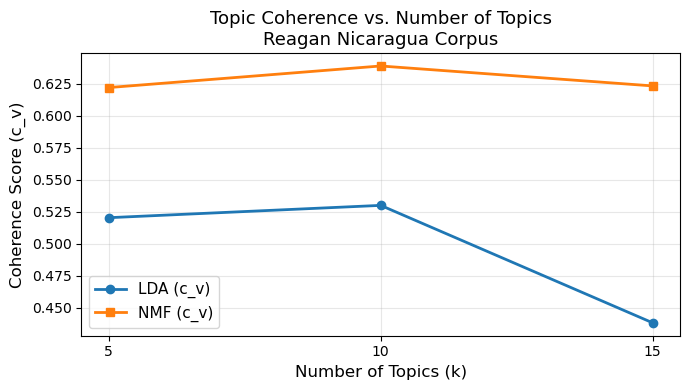


Interpretation: A higher coherence score indicates that the top words
within each topic co-occur more frequently in the corpus -- i.e., the topics
are more semantically coherent and human-interpretable.


In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 9: Coherence Plot
# ─────────────────────────────────────────────────────────────────────────────

lda_scores = [results[k]['lda_coherence'] for k in K_VALUES]
nmf_scores = [results[k]['nmf_coherence'] for k in K_VALUES]

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(K_VALUES, lda_scores, marker='o', linewidth=2, label='LDA (c_v)')
ax.plot(K_VALUES, nmf_scores, marker='s', linewidth=2, label='NMF (c_v)')

ax.set_xlabel('Number of Topics (k)', fontsize=12)
ax.set_ylabel('Coherence Score (c_v)', fontsize=12)
ax.set_title('Topic Coherence vs. Number of Topics\nReagan Nicaragua Corpus', fontsize=13)
ax.xaxis.set_major_locator(ticker.FixedLocator(K_VALUES))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation: A higher coherence score indicates that the top words")
print("within each topic co-occur more frequently in the corpus -- i.e., the topics")
print("are more semantically coherent and human-interpretable.")

---
## Step 4: Inspecting Topics

Below we display the **top 10 words** for every topic, for all three values of k, and for both LDA and NMF. This is the core interpretive step: looking at these word lists, we can manually assign meaningful labels to each topic (e.g., *Anticommunism*, *Counternarcotics*, *Contra Aid Debate*, *Diplomacy*, etc.).

Words are ranked by their weight within each topic -- the higher the weight, the more strongly that word "belongs" to that topic relative to the others.

In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 11: Display Top-10 Words for All Models
# ─────────────────────────────────────────────────────────────────────────────

for k in K_VALUES:
    for model_name in ['lda', 'nmf']:
        label = model_name.upper()
        words = results[k][f'{model_name}_words']
        coh   = results[k][f'{model_name}_coherence']

        print(f"\n{'='*60}")
        print(f"  {label} | k={k}   (coherence: {coh:.4f})")
        print(f"{'='*60}")
        for i, topic_words in enumerate(words):
            print(f"  Topic {i+1:>2}: {', '.join(topic_words)}")


  LDA | k=5   (coherence: 0.5203)
  Topic  1: audience, tax, opponent, could, day, great, senator, economic, thank, long
  Topic  2: freedom, tax, like, day, great, thank, many, ago, god, much
  Topic  3: soviet, peace, freedom, economic, country, human, free, right, union, nation
  Topic  4: thing, could, soviet, question, weapon, like, kind, tax, yes, made
  Topic  5: central, democracy, democratic, sandinistas, freedom, communist, peace, fighter, security, sandinista

  NMF | k=5   (coherence: 0.6219)
  Topic  1: tax, budget, rate, thing, republican, like, job, spending, audience, program
  Topic  2: sandinistas, central, democracy, democratic, resistance, salvador, communist, freedom, assistance, sandinista
  Topic  3: soviet, weapon, nuclear, thing, arm, could, missile, agreement, union, summit
  Topic  4: emergency, national, may, act, pursuant, report, section, license, register, sanction
  Topic  5: freedom, human, right, soviet, nation, free, liberty, peace, life, cause

  LD

---
## Step 5: Document-Topic Distribution

The topic word lists tell us what each topic *is*. Now we want to know: for each document (each speech or statement), **which topic dominates, and how strongly?**

Both LDA and NMF produce a **document-topic matrix** -- a table where each row is a document and each column is a topic, and each cell contains the weight (or probability) of that topic in that document. We:
1. Find the **dominant topic** for each document (`argmax` -- the topic with the highest weight)
2. Record the **topic weight** (how concentrated the document is on that dominant topic; closer to 1.0 = more focused)
3. Merge with the original metadata (date, title) for interpretability

This allows us to answer questions like: *"How many speeches are primarily about counternarcotics vs. anticommunism?"* or *"Did the dominant framing shift over time?"*

In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# CELL 13: Document-Topic Distribution Tables
# ─────────────────────────────────────────────────────────────────────────────

meta_df = pd.read_csv(META_PATH)

for k in K_VALUES:
    for model_name in ['lda', 'nmf']:
        model = results[k][model_name]
        label = model_name.upper()

        # .transform() projects documents into topic space using the trained model
        if model_name == 'lda':
            doc_topic = model.transform(dtm_count)
        else:
            doc_topic = model.transform(dtm_tfidf)

        # NMF values don't sum to 1 -- normalize rows to make them comparable
        # to LDA's probability distributions.
        if model_name == 'nmf':
            row_sums = doc_topic.sum(axis=1, keepdims=True)
            row_sums[row_sums == 0] = 1
            doc_topic = doc_topic / row_sums

        dominant_topic = np.argmax(doc_topic, axis=1) + 1   # 1-indexed
        topic_weight   = np.max(doc_topic, axis=1)

        result_df = pd.DataFrame({
            'filename'      : doc_filenames,
            'dominant_topic': dominant_topic,
            'topic_weight'  : topic_weight.round(4)
        })

        merged = result_df.merge(meta_df[['filename', 'date', 'title']], on='filename')
        merged = merged[['filename', 'date', 'title', 'dominant_topic', 'topic_weight']]
        merged = merged.sort_values('filename').reset_index(drop=True)

        print(f"\n{'='*70}")
        print(f"  {label} | k={k}  --  Document-Topic Distribution")
        print(f"  Total documents: {len(merged)}")
        print(f"  Topic distribution (document counts):")
        topic_counts = merged['dominant_topic'].value_counts().sort_index()
        for topic_id, count in topic_counts.items():
            pct = count / len(merged) * 100
            print(f"    Topic {topic_id:>2}: {count:>4} docs  ({pct:.1f}%)")
        print(f"{'='*70}")

        display(merged.head(20))


  LDA | k=5  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:   14 docs  (2.9%)
    Topic  2:  117 docs  (24.1%)
    Topic  3:  110 docs  (22.7%)
    Topic  4:  111 docs  (22.9%)
    Topic  5:  133 docs  (27.4%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,3,0.6548
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,3,0.3776
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,4,0.9453
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,5,0.5688
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,3,0.7529
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,1,0.4197
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,5,0.9845
7,doc_007.txt,18-Feb-82,The President's News Conference,4,0.9231
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,4,0.9992
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,3,0.8227



  NMF | k=5  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:  109 docs  (22.5%)
    Topic  2:  137 docs  (28.2%)
    Topic  3:  125 docs  (25.8%)
    Topic  4:   38 docs  (7.8%)
    Topic  5:   76 docs  (15.7%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,3,0.4789
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,3,0.3658
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,3,0.4588
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,4,0.5093
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,5,0.6214
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,4,0.4645
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,4,0.7212
7,doc_007.txt,18-Feb-82,The President's News Conference,1,0.5235
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,1,0.6047
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,2,0.3875



  LDA | k=10  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:    5 docs  (1.0%)
    Topic  3:   79 docs  (16.3%)
    Topic  5:    5 docs  (1.0%)
    Topic  6:  148 docs  (30.5%)
    Topic  7:   10 docs  (2.1%)
    Topic  8:   26 docs  (5.4%)
    Topic  9:  203 docs  (41.9%)
    Topic 10:    9 docs  (1.9%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,6,0.6892
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,9,0.6707
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,9,0.9922
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,1,0.9868
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,6,0.5312
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,1,0.9132
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,8,0.8954
7,doc_007.txt,18-Feb-82,The President's News Conference,9,0.9764
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,9,0.9894
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,3,0.6318



  NMF | k=10  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:   82 docs  (16.9%)
    Topic  2:   60 docs  (12.4%)
    Topic  3:   65 docs  (13.4%)
    Topic  4:   17 docs  (3.5%)
    Topic  5:   68 docs  (14.0%)
    Topic  6:   80 docs  (16.5%)
    Topic  7:   10 docs  (2.1%)
    Topic  8:   47 docs  (9.7%)
    Topic  9:   18 docs  (3.7%)
    Topic 10:   38 docs  (7.8%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,3,0.4429
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,3,0.2408
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,1,0.4756
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,9,0.9901
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,6,0.5210
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,9,0.9405
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,9,1.0000
7,doc_007.txt,18-Feb-82,The President's News Conference,1,0.4453
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,1,0.5297
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,6,0.8272



  LDA | k=15  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:    1 docs  (0.2%)
    Topic  3:    2 docs  (0.4%)
    Topic  5:    1 docs  (0.2%)
    Topic  6:  162 docs  (33.4%)
    Topic  7:   10 docs  (2.1%)
    Topic  9:  223 docs  (46.0%)
    Topic 10:   22 docs  (4.5%)
    Topic 11:    5 docs  (1.0%)
    Topic 14:   52 docs  (10.7%)
    Topic 15:    7 docs  (1.4%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,6,0.5893
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,9,0.7369
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,9,0.8717
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,14,0.8796
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,6,0.7026
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,14,0.8339
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,14,0.9824
7,doc_007.txt,18-Feb-82,The President's News Conference,9,0.9595
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,9,0.9619
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,6,0.6230



  NMF | k=15  --  Document-Topic Distribution
  Total documents: 485
  Topic distribution (document counts):
    Topic  1:   44 docs  (9.1%)
    Topic  2:   47 docs  (9.7%)
    Topic  3:   64 docs  (13.2%)
    Topic  4:    6 docs  (1.2%)
    Topic  5:   48 docs  (9.9%)
    Topic  6:   46 docs  (9.5%)
    Topic  7:   10 docs  (2.1%)
    Topic  8:   39 docs  (8.0%)
    Topic  9:   13 docs  (2.7%)
    Topic 10:   26 docs  (5.4%)
    Topic 11:   10 docs  (2.1%)
    Topic 12:   53 docs  (10.9%)
    Topic 13:   44 docs  (9.1%)
    Topic 14:    8 docs  (1.6%)
    Topic 15:   27 docs  (5.6%)


,filename,date,title,dominant_topic,topic_weight
0,doc_000.txt,18-Aug-80,Address to the Veterans of Foreign Wars Conven...,3,0.4194
1,doc_001.txt,20-Jan-81,Ronald Reagan Event Timeline,15,0.4862
2,doc_002.txt,3-Mar-81,Excerpts From an Interview With Walter Cronkit...,1,0.3435
3,doc_003.txt,6-Nov-81,Nomination of James Daniel Theberge To Be Unit...,9,0.9729
4,doc_004.txt,17-Nov-81,Toasts of the President and President Luis Her...,13,0.4917
5,doc_005.txt,16-Dec-81,Appointment of Three Members of the Board of F...,9,0.8593
6,doc_006.txt,13-Jan-82,Nomination of Anthony Cecil Eden Quainton To B...,9,0.9992
7,doc_007.txt,18-Feb-82,The President's News Conference,12,0.3518
8,doc_008.txt,19-Feb-82,Remarks and a Question-and-Answer Session on t...,12,0.4885
9,doc_009.txt,24-Feb-82,Remarks on the Caribbean Basin Initiative to t...,13,0.5540
